# Обучение нейросетей — оптимизация и регуляризация

**Разработчик: Артем Бабенко**

На это семинаре будет необходимо (1) реализовать Dropout-слой и проследить его влияние на обобщающую способность сети (2) реализовать BatchNormalization-слой и пронаблюдать его влияние на скорость сходимости обучения.

## Dropout (0.6 балла)

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

9920512it [00:07, 1332216.55it/s]                                                                                                        


Extracting ./MNIST/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST/MNIST\raw


32768it [00:00, 53226.68it/s]                                                                                                            


Extracting ./MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw


1654784it [00:02, 604880.05it/s]                                                                                                         


Extracting ./MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST/MNIST\raw


8192it [00:00, 11696.19it/s]                                                                                                             


Extracting ./MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw
Processing...
Done!


Определим ряд стандартных функций с прошлых семинаров

In [15]:
def train_epoch(model, optimizer, batchsize=32, cuda=True):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch.cuda() if cuda else x_batch
        target = y_batch.cuda() if cuda else y_batch

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1].cpu()
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log    

def test(model, cuda=True):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = x_batch.cuda() if cuda else x_batch
        target = y_batch.cuda() if cuda else y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1].cpu()
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs, cuda=True):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size, cuda=cuda)

        val_loss, val_acc = test(model, cuda=cuda)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
        
        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

In [16]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, num_classes),
    nn.Softmax(dim=-1)
    )

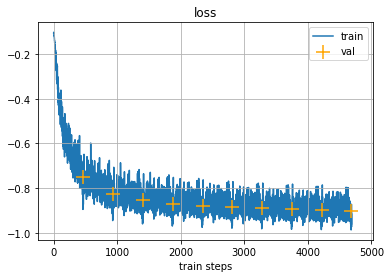

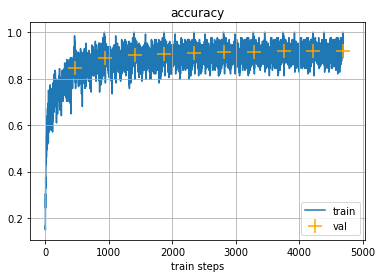

Epoch: 9, val loss: -0.9009133713154853, val accuracy: 0.9197982549667358


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=-1)
)

In [17]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
model.cuda()
train(model, opt, 10)
model.cpu()

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

torch.Size([10, 784])


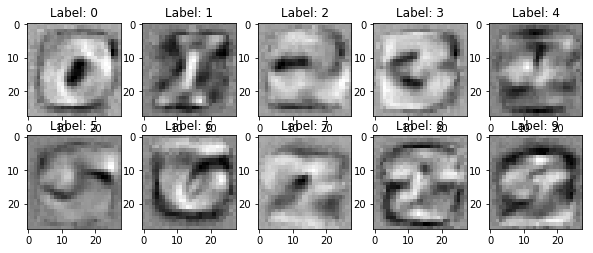

In [33]:
weights = list(model.modules())[2].weight.detach()
print(weights.size())
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения. 

In [70]:
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        self._prob = p
        self._scale = 1 / ( 1 - self._prob)

    def forward(self, inp):
        if self.training:
            return self.__train_mode(inp)
        else:
            return inp
    def __train_mode(self, inp):
        probs = torch.full(size=inp.size(), fill_value=(1 - self._prob))
        dist = torch.distributions.Bernoulli(probs)
        mask = dist.sample()
        if inp.is_cuda:
            mask = mask.cuda()
        return inp * mask * self._scale

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [80]:
modelDp = nn.Sequential(
    Flatten(),
    DropoutLayer(0.7),
    nn.Linear(input_size, num_classes),
    nn.Softmax(dim=-1)
    )

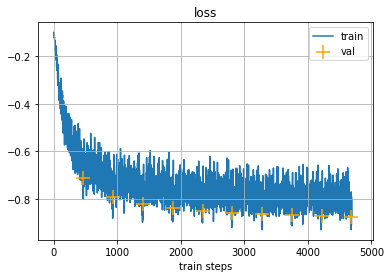

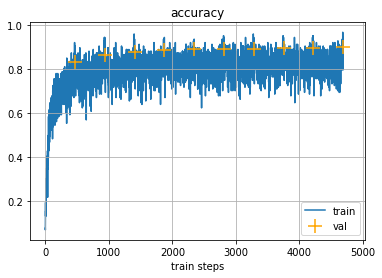

Epoch: 9, val loss: -0.8754886351054227, val accuracy: 0.900217592716217


Sequential(
  (0): Flatten()
  (1): DropoutLayer()
  (2): Linear(in_features=784, out_features=10, bias=True)
  (3): Softmax(dim=-1)
)

In [81]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
modelDp.cuda()
train(modelDp, opt, 10)
modelDp.cpu()

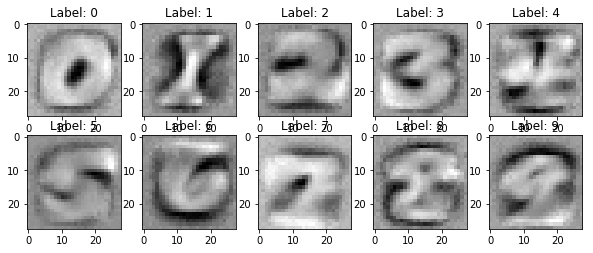

In [83]:
weights = list(modelDp.modules())[3].weight.detach()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [84]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

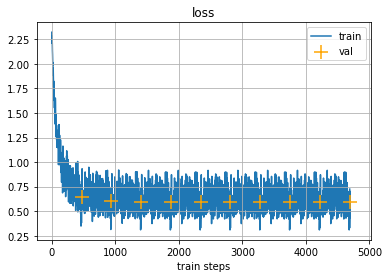

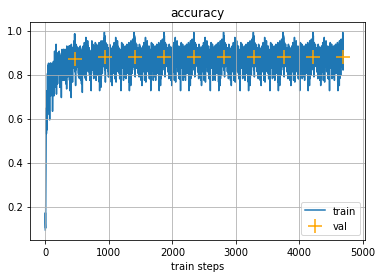

Epoch: 9, val loss: 0.5904818711024297, val accuracy: 0.8812302350997925


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): LogSoftmax()
)

In [86]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)
model.cuda()
train(model, opt, 10)
model.cpu()

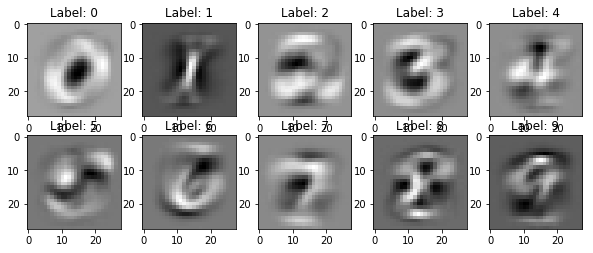

In [88]:
weights = list(model.modules())[2].weight.detach()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

## Batch normalization (0.4 балла)

Реализуйте BatchNormalization слой для полносвязной сети. В реализации достаточно только центрировать и разделить на корень из дисперсии, аффинную поправку (гамма и бета) в этом задании можно не реализовывать.

In [ ]:
class BnLayer(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        #<your code>

    def forward(self, inp):
        if self.training:
            #<your code>
        else:
            #<your code>
        return #<your code>

Обучите трехслойную полносвязную сеть (размер скрытого слоя возьмите 100) с сигмоидами в качестве функций активации. 

In [ ]:
model = nn.Sequential(
    #<your code>
    )

In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)
train(model, opt, 3)

Повторите обучение с теми же параметрами для сети с той же архитектурой, но с добавлением BatchNorm слоя (для всех трех скрытых слоев).

In [ ]:
modelBN = nn.Sequential(
    #<your code>
    )

In [ ]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

Сравните кривые обучения и сделайте вывод о влиянии BatchNorm на ход обучения.